In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Import data

In [2]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


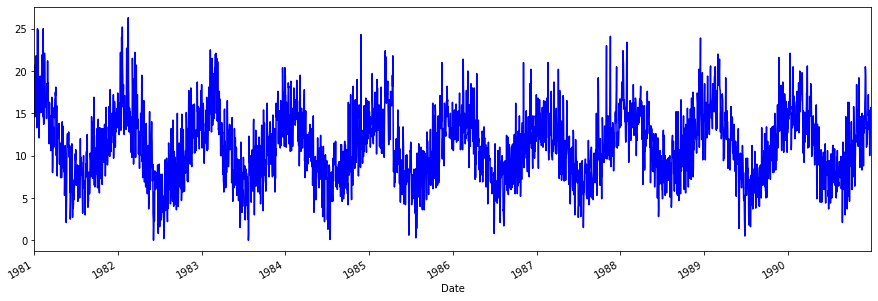

In [3]:
df.Temp.plot(figsize=(15, 5), color='b')

## Dataset Splitting

In [4]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape,ts_test.shape

((2920, 1), (730, 1))

## Dataset & Dataloader

In [5]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [6]:
bs = 32
seq_len = 14

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs, num_workers=4)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



## Arsitektur & Config

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layer, dropout, batch_first=True):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layer, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
        

In [8]:
config = set_config({
    "input_size": 1,
    "output_size": 1,
    "seq_len": 14,
    "bs": 32,
    "hidden_size": 64,
    "num_layer": 2,
    "drop_out": 0
})

## Training Preparation => MCOC

In [9]:
model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layer, config.drop_out).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/lstm")

## Training

In [10]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 135.6726 | Test_cost  = 135.6960 | 




Epoch     2
Train_cost  = 119.9496 | Test_cost  = 113.3294 | 




Epoch     3
Train_cost  = 96.2567 | Test_cost  = 88.7908 | 




Epoch     4
Train_cost  = 74.7650 | Test_cost  = 70.0747 | 




Epoch     5
Train_cost  = 59.0791 | Test_cost  = 56.9162 | 




Epoch     6
Train_cost  = 48.4405 | Test_cost  = 48.0756 | 




Epoch     7
Train_cost  = 41.2236 | Test_cost  = 41.6821 | 




Epoch     8
Train_cost  = 35.9127 | Test_cost  = 36.7843 | 




Epoch     9
Train_cost  = 31.8530 | Test_cost  = 32.9467 | 




Epoch    10
Train_cost  = 28.6778 | Test_cost  = 29.8670 | 




Epoch    11
Train_cost  = 26.1558 | Test_cost  = 27.3920 | 




Epoch    12
Train_cost  = 24.1688 | Test_cost  = 25.4234 | 




Epoch    13
Train_cost  = 22.6176 | Test_cost  = 23.8631 | 




Epoch    14
Train_cost  = 21.4135 | Test_cost  = 22.6309 | 




Epoch    15
Train_cost  = 20.4837 | Test_cost  = 21.6602 | 




Epoch    16
Train_cost  = 19.7687 | Test_cost  = 20.8963 | 




Epoch    17
Train_cost  = 19.2194 | Test_cost  = 20.2946 | 




Epoch    18
Train_cost  = 18.7969 | Test_cost  = 19.8189 | 




Epoch    19
Train_cost  = 18.4699 | Test_cost  = 19.4406 | 




Epoch    20
Train_cost  = 18.2144 | Test_cost  = 19.1376 | 


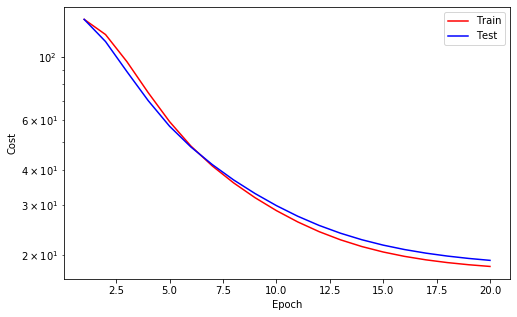



Epoch    21
Train_cost  = 18.0122 | Test_cost  = 18.8928 | 




Epoch    22
Train_cost  = 17.8499 | Test_cost  = 18.6936 | 




Epoch    23
Train_cost  = 17.7179 | Test_cost  = 18.5306 | 




Epoch    24
Train_cost  = 17.6091 | Test_cost  = 18.3963 | 




Epoch    25
Train_cost  = 17.5184 | Test_cost  = 18.2853 | 




Epoch    26
Train_cost  = 17.4421 | Test_cost  = 18.1930 | 




Epoch    27
Train_cost  = 17.3772 | Test_cost  = 18.1159 | 




Epoch    28
Train_cost  = 17.3215 | Test_cost  = 18.0509 | 




Epoch    29
Train_cost  = 17.2732 | Test_cost  = 17.9960 | 




Epoch    30
Train_cost  = 17.2311 | Test_cost  = 17.9490 | 




Epoch    31
Train_cost  = 17.1940 | Test_cost  = 17.9087 | 




Epoch    32
Train_cost  = 17.1612 | Test_cost  = 17.8737 | 




Epoch    33
Train_cost  = 17.1319 | Test_cost  = 17.8430 | 




Epoch    34
Train_cost  = 17.1056 | Test_cost  = 17.8160 | 




Epoch    35
Train_cost  = 17.0818 | Test_cost  = 17.7918 | 




Epoch    36
Train_cost  = 17.0596 | Test_cost  = 17.7681 | 




Epoch    37
Train_cost  = 17.0363 | Test_cost  = 17.7457 | 




Epoch    38
Train_cost  = 17.0174 | Test_cost  = 17.7293 | 




Epoch    39
Train_cost  = 17.0015 | Test_cost  = 17.7128 | 




Epoch    40
Train_cost  = 16.9862 | Test_cost  = 17.6971 | 


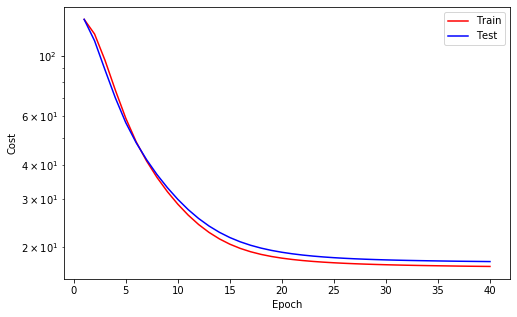



Epoch    41
Train_cost  = 16.9720 | Test_cost  = 17.6830 | 




Epoch    42
Train_cost  = 16.9591 | Test_cost  = 17.6702 | 




Epoch    43
Train_cost  = 16.9469 | Test_cost  = 17.6584 | 




Epoch    44
Train_cost  = 16.9356 | Test_cost  = 17.6473 | 




Epoch    45
Train_cost  = 16.9248 | Test_cost  = 17.6367 | 




Epoch    46
Train_cost  = 16.9145 | Test_cost  = 17.6266 | 




Epoch    47
Train_cost  = 16.9043 | Test_cost  = 17.6165 | 




Epoch    48
Train_cost  = 16.8936 | Test_cost  = 17.6051 | 




Epoch    49
Train_cost  = 16.8804 | Test_cost  = 17.5914 | 




Epoch    50
Train_cost  = 16.8658 | Test_cost  = 17.5776 | 




Epoch    51
Train_cost  = 16.8507 | Test_cost  = 17.5653 | 




Epoch    52
Train_cost  = 16.8385 | Test_cost  = 17.5543 | 




Epoch    53
Train_cost  = 16.8267 | Test_cost  = 17.5421 | 




Epoch    54
Train_cost  = 16.8137 | Test_cost  = 17.5280 | 




Epoch    55
Train_cost  = 16.7982 | Test_cost  = 17.5091 | 




Epoch    56
Train_cost  = 16.7749 | Test_cost  = 17.4832 | 




Epoch    57
Train_cost  = 16.7494 | Test_cost  = 17.4575 | 




Epoch    58
Train_cost  = 16.7133 | Test_cost  = 17.4108 | 




Epoch    59
Train_cost  = 16.6540 | Test_cost  = 17.3365 | 




Epoch    60
Train_cost  = 16.5388 | Test_cost  = 17.1287 | 


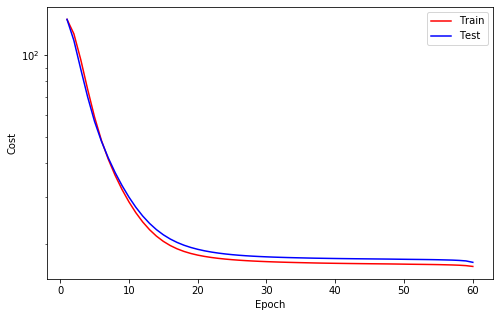



Epoch    61
Train_cost  = 16.3106 | Test_cost  = 16.9038 | 




Epoch    62
Train_cost  = 16.0366 | Test_cost  = 16.4969 | 




Epoch    63
Train_cost  = 15.4574 | Test_cost  = 15.3787 | 




Epoch    64
Train_cost  = 14.1320 | Test_cost  = 13.9535 | 




Epoch    65
Train_cost  = 12.8247 | Test_cost  = 12.9055 | 




Epoch    66
Train_cost  = 12.0084 | Test_cost  = 11.7302 | 




Epoch    67
Train_cost  = 11.1318 | Test_cost  = 10.9141 | 




Epoch    68
Train_cost  = 10.4685 | Test_cost  = 10.3060 | 




Epoch    69
Train_cost  = 10.0236 | Test_cost  = 9.6516 | 




Epoch    70
Train_cost  = 9.5176 | Test_cost  = 9.1514 | 




Epoch    71
Train_cost  = 9.1433 | Test_cost  = 8.7778 | 




Epoch    72
Train_cost  = 8.8805 | Test_cost  = 8.4430 | 




Epoch    73
Train_cost  = 8.6098 | Test_cost  = 8.1685 | 




Epoch    74
Train_cost  = 8.4003 | Test_cost  = 7.9398 | 




Epoch    75
Train_cost  = 8.2218 | Test_cost  = 7.7355 | 




Epoch    76
Train_cost  = 8.0578 | Test_cost  = 7.5613 | 




Epoch    77
Train_cost  = 7.9197 | Test_cost  = 7.4088 | 




Epoch    78
Train_cost  = 7.8020 | Test_cost  = 7.2722 | 




Epoch    79
Train_cost  = 7.6928 | Test_cost  = 7.1544 | 




Epoch    80
Train_cost  = 7.5986 | Test_cost  = 7.0496 | 


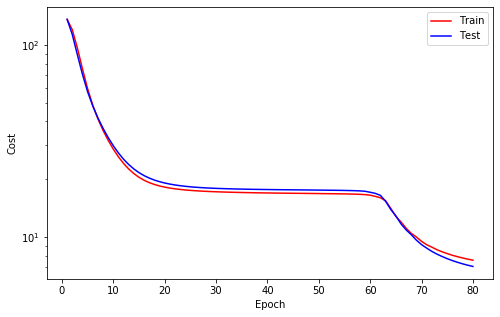



Epoch    81
Train_cost  = 7.5167 | Test_cost  = 6.9539 | 




Epoch    82
Train_cost  = 7.4410 | Test_cost  = 6.8682 | 




Epoch    83
Train_cost  = 7.3730 | Test_cost  = 6.7893 | 




Epoch    84
Train_cost  = 7.3121 | Test_cost  = 6.7165 | 




Epoch    85
Train_cost  = 7.2565 | Test_cost  = 6.6499 | 




Epoch    86
Train_cost  = 7.2056 | Test_cost  = 6.5883 | 




Epoch    87
Train_cost  = 7.1588 | Test_cost  = 6.5317 | 




Epoch    88
Train_cost  = 7.1159 | Test_cost  = 6.4792 | 




Epoch    89
Train_cost  = 7.0762 | Test_cost  = 6.4306 | 




Epoch    90
Train_cost  = 7.0394 | Test_cost  = 6.3851 | 




Epoch    91
Train_cost  = 7.0053 | Test_cost  = 6.3423 | 




Epoch    92
Train_cost  = 6.9733 | Test_cost  = 6.3022 | 




Epoch    93
Train_cost  = 6.9432 | Test_cost  = 6.2643 | 




Epoch    94
Train_cost  = 6.9148 | Test_cost  = 6.2287 | 




Epoch    95
Train_cost  = 6.8878 | Test_cost  = 6.1949 | 




Epoch    96
Train_cost  = 6.8621 | Test_cost  = 6.1627 | 




Epoch    97
Train_cost  = 6.8375 | Test_cost  = 6.1318 | 




Epoch    98
Train_cost  = 6.8138 | Test_cost  = 6.1021 | 




Epoch    99
Train_cost  = 6.7910 | Test_cost  = 6.0735 | 




Epoch   100
Train_cost  = 6.7688 | Test_cost  = 6.0460 | 


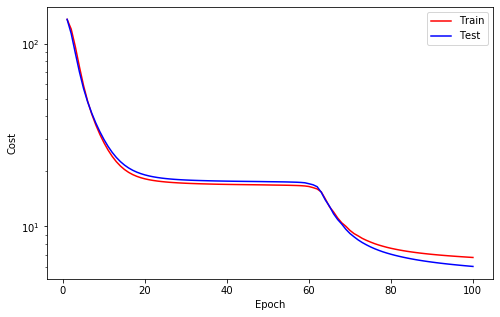



Epoch   101
Train_cost  = 6.7474 | Test_cost  = 6.0195 | 




Epoch   102
Train_cost  = 6.7266 | Test_cost  = 5.9939 | 




Epoch   103
Train_cost  = 6.7063 | Test_cost  = 5.9692 | 




Epoch   104
Train_cost  = 6.6866 | Test_cost  = 5.9453 | 




Epoch   105
Train_cost  = 6.6675 | Test_cost  = 5.9222 | 




Epoch   106
Train_cost  = 6.6488 | Test_cost  = 5.9000 | 




Epoch   107
Train_cost  = 6.6306 | Test_cost  = 5.8784 | 




Epoch   108
Train_cost  = 6.6128 | Test_cost  = 5.8576 | 




Epoch   109
Train_cost  = 6.5954 | Test_cost  = 5.8373 | 




Epoch   110
Train_cost  = 6.5785 | Test_cost  = 5.8174 | 




Epoch   111
Train_cost  = 6.5619 | Test_cost  = 5.7980 | 




Epoch   112
Train_cost  = 6.5458 | Test_cost  = 5.7793 | 




Epoch   113
Train_cost  = 6.5302 | Test_cost  = 5.7613 | 




Epoch   114
Train_cost  = 6.5154 | Test_cost  = 5.7441 | 




Epoch   115
Train_cost  = 6.5013 | Test_cost  = 5.7280 | 




Epoch   116
Train_cost  = 6.4879 | Test_cost  = 5.7127 | 




Epoch   117
Train_cost  = 6.4752 | Test_cost  = 5.6982 | 




Epoch   118
Train_cost  = 6.4630 | Test_cost  = 5.6843 | 




Epoch   119
Train_cost  = 6.4512 | Test_cost  = 5.6709 | 




Epoch   120
Train_cost  = 6.4398 | Test_cost  = 5.6578 | 


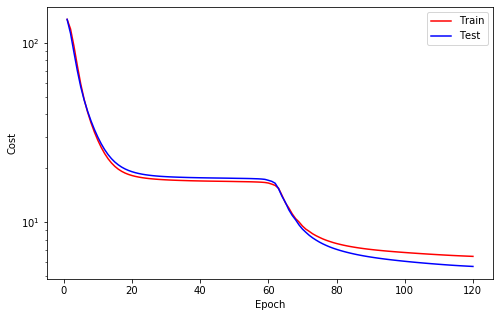



Epoch   121
Train_cost  = 6.4286 | Test_cost  = 5.6449 | 




Epoch   122
Train_cost  = 6.4177 | Test_cost  = 5.6322 | 




Epoch   123
Train_cost  = 6.4070 | Test_cost  = 5.6197 | 




Epoch   124
Train_cost  = 6.3966 | Test_cost  = 5.6077 | 




Epoch   125
Train_cost  = 6.3865 | Test_cost  = 5.5961 | 




Epoch   126
Train_cost  = 6.3768 | Test_cost  = 5.5851 | 




Epoch   127
Train_cost  = 6.3674 | Test_cost  = 5.5746 | 




Epoch   128
Train_cost  = 6.3584 | Test_cost  = 5.5645 | 




Epoch   129
Train_cost  = 6.3496 | Test_cost  = 5.5546 | 




Epoch   130
Train_cost  = 6.3409 | Test_cost  = 5.5448 | 




Epoch   131
Train_cost  = 6.3324 | Test_cost  = 5.5348 | 




Epoch   132
Train_cost  = 6.3238 | Test_cost  = 5.5248 | 




Epoch   133
Train_cost  = 6.3154 | Test_cost  = 5.5147 | 




Epoch   134
Train_cost  = 6.3071 | Test_cost  = 5.5049 | 




Epoch   135
Train_cost  = 6.2990 | Test_cost  = 5.4955 | 




Epoch   136
Train_cost  = 6.2913 | Test_cost  = 5.4866 | 




Epoch   137
Train_cost  = 6.2838 | Test_cost  = 5.4780 | 




Epoch   138
Train_cost  = 6.2767 | Test_cost  = 5.4696 | 




Epoch   139
Train_cost  = 6.2696 | Test_cost  = 5.4612 | 




Epoch   140
Train_cost  = 6.2626 | Test_cost  = 5.4524 | 


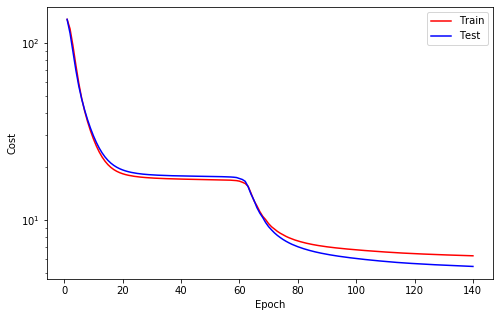



Epoch   141
Train_cost  = 6.2555 | Test_cost  = 5.4433 | 




Epoch   142
Train_cost  = 6.2483 | Test_cost  = 5.4339 | 




Epoch   143
Train_cost  = 6.2410 | Test_cost  = 5.4246 | 




Epoch   144
Train_cost  = 6.2339 | Test_cost  = 5.4157 | 




Epoch   145
Train_cost  = 6.2272 | Test_cost  = 5.4077 | 




Epoch   146
Train_cost  = 6.2209 | Test_cost  = 5.4009 | 




Epoch   147
Train_cost  = 6.2149 | Test_cost  = 5.3950 | 




Epoch   148
Train_cost  = 6.2090 | Test_cost  = 5.3894 | 




Epoch   149
Train_cost  = 6.2032 | Test_cost  = 5.3833 | 




Epoch   150
Train_cost  = 6.1975 | Test_cost  = 5.3762 | 




Epoch   151
Train_cost  = 6.1918 | Test_cost  = 5.3695 | 




Epoch   152
Train_cost  = 6.1861 | Test_cost  = 5.3642 | 




Epoch   153
Train_cost  = 6.1807 | Test_cost  = 5.3594 | 




Epoch   154
Train_cost  = 6.1754 | Test_cost  = 5.3542 | 




Epoch   155
Train_cost  = 6.1700 | Test_cost  = 5.3486 | 




Epoch   156
Train_cost  = 6.1646 | Test_cost  = 5.3434 | 




Epoch   157
Train_cost  = 6.1594 | Test_cost  = 5.3387 | 




Epoch   158
Train_cost  = 6.1543 | Test_cost  = 5.3344 | 




Epoch   159
Train_cost  = 6.1493 | Test_cost  = 5.3303 | 




Epoch   160
Train_cost  = 6.1442 | Test_cost  = 5.3260 | 


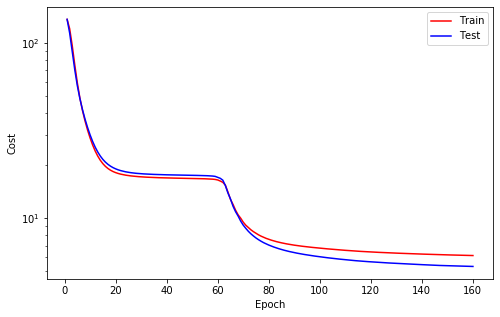



Epoch   161
Train_cost  = 6.1391 | Test_cost  = 5.3214 | 




Epoch   162
Train_cost  = 6.1340 | Test_cost  = 5.3166 | 




Epoch   163
Train_cost  = 6.1290 | Test_cost  = 5.3120 | 




Epoch   164
Train_cost  = 6.1241 | Test_cost  = 5.3076 | 




Epoch   165
Train_cost  = 6.1194 | Test_cost  = 5.3035 | 




Epoch   166
Train_cost  = 6.1148 | Test_cost  = 5.2996 | 




Epoch   167
Train_cost  = 6.1103 | Test_cost  = 5.2959 | 




Epoch   168
Train_cost  = 6.1058 | Test_cost  = 5.2921 | 




Epoch   169
Train_cost  = 6.1012 | Test_cost  = 5.2883 | 




Epoch   170
Train_cost  = 6.0967 | Test_cost  = 5.2843 | 




Epoch   171
Train_cost  = 6.0921 | Test_cost  = 5.2805 | 




Epoch   172
Train_cost  = 6.0877 | Test_cost  = 5.2768 | 




Epoch   173
Train_cost  = 6.0833 | Test_cost  = 5.2732 | 




Epoch   174
Train_cost  = 6.0790 | Test_cost  = 5.2698 | 




Epoch   175
Train_cost  = 6.0747 | Test_cost  = 5.2664 | 




Epoch   176
Train_cost  = 6.0704 | Test_cost  = 5.2630 | 




Epoch   177
Train_cost  = 6.0662 | Test_cost  = 5.2596 | 




Epoch   178
Train_cost  = 6.0619 | Test_cost  = 5.2562 | 




Epoch   179
Train_cost  = 6.0577 | Test_cost  = 5.2529 | 




Epoch   180
Train_cost  = 6.0536 | Test_cost  = 5.2496 | 


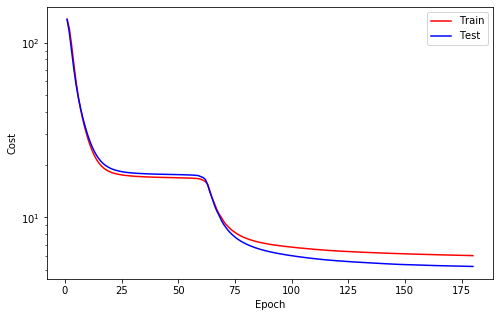



Epoch   181
Train_cost  = 6.0495 | Test_cost  = 5.2464 | 




Epoch   182
Train_cost  = 6.0455 | Test_cost  = 5.2433 | 




Epoch   183
Train_cost  = 6.0414 | Test_cost  = 5.2401 | 




Epoch   184
Train_cost  = 6.0374 | Test_cost  = 5.2369 | 




Epoch   185
Train_cost  = 6.0334 | Test_cost  = 5.2337 | 




Epoch   186
Train_cost  = 6.0296 | Test_cost  = 5.2306 | 




Epoch   187
Train_cost  = 6.0258 | Test_cost  = 5.2279 | 




Epoch   188
Train_cost  = 6.0222 | Test_cost  = 5.2255 | 




Epoch   189
Train_cost  = 6.0187 | Test_cost  = 5.2237 | 




Epoch   190
Train_cost  = 6.0154 | Test_cost  = 5.2223 | 




Epoch   191
Train_cost  = 6.0122 | Test_cost  = 5.2213 | 




Epoch   192
Train_cost  = 6.0089 | Test_cost  = 5.2199 | 




Epoch   193
Train_cost  = 6.0051 | Test_cost  = 5.2180 | 




Epoch   194
Train_cost  = 6.0011 | Test_cost  = 5.2151 | 




Epoch   195
Train_cost  = 5.9968 | Test_cost  = 5.2115 | 




Epoch   196
Train_cost  = 5.9928 | Test_cost  = 5.2069 | 




Epoch   197
Train_cost  = 5.9890 | Test_cost  = 5.2035 | 




Epoch   198
Train_cost  = 5.9860 | Test_cost  = 5.2026 | 




Epoch   199
Train_cost  = 5.9831 | Test_cost  = 5.2035 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2026




Epoch   200
Train_cost  = 5.9802 | Test_cost  = 5.2028 | 


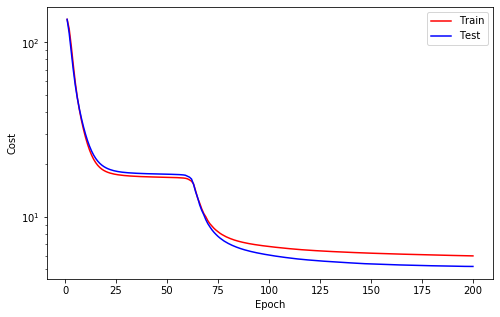

==> EarlyStop patience =  2 | Best test_cost: 5.2026




Epoch   201
Train_cost  = 5.9762 | Test_cost  = 5.2007 | 




Epoch   202
Train_cost  = 5.9717 | Test_cost  = 5.1960 | 




Epoch   203
Train_cost  = 5.9667 | Test_cost  = 5.1922 | 




Epoch   204
Train_cost  = 5.9630 | Test_cost  = 5.1888 | 




Epoch   205
Train_cost  = 5.9596 | Test_cost  = 5.1883 | 




Epoch   206
Train_cost  = 5.9570 | Test_cost  = 5.1872 | 




Epoch   207
Train_cost  = 5.9535 | Test_cost  = 5.1871 | 




Epoch   208
Train_cost  = 5.9501 | Test_cost  = 5.1842 | 




Epoch   209
Train_cost  = 5.9455 | Test_cost  = 5.1827 | 




Epoch   210
Train_cost  = 5.9418 | Test_cost  = 5.1794 | 




Epoch   211
Train_cost  = 5.9374 | Test_cost  = 5.1792 | 




Epoch   212
Train_cost  = 5.9342 | Test_cost  = 5.1764 | 




Epoch   213
Train_cost  = 5.9295 | Test_cost  = 5.1762 | 




Epoch   214
Train_cost  = 5.9259 | Test_cost  = 5.1722 | 




Epoch   215
Train_cost  = 5.9208 | Test_cost  = 5.1718 | 




Epoch   216
Train_cost  = 5.9174 | Test_cost  = 5.1678 | 




Epoch   217
Train_cost  = 5.9126 | Test_cost  = 5.1686 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1678




Epoch   218
Train_cost  = 5.9101 | Test_cost  = 5.1647 | 




Epoch   219
Train_cost  = 5.9057 | Test_cost  = 5.1666 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1647




Epoch   220
Train_cost  = 5.9036 | Test_cost  = 5.1622 | 


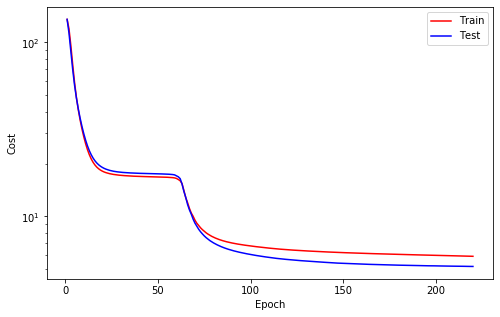



Epoch   221
Train_cost  = 5.8988 | Test_cost  = 5.1644 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1622




Epoch   222
Train_cost  = 5.8967 | Test_cost  = 5.1592 | 




Epoch   223
Train_cost  = 5.8916 | Test_cost  = 5.1618 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1592




Epoch   224
Train_cost  = 5.8898 | Test_cost  = 5.1558 | 




Epoch   225
Train_cost  = 5.8848 | Test_cost  = 5.1596 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1558




Epoch   226
Train_cost  = 5.8837 | Test_cost  = 5.1529 | 




Epoch   227
Train_cost  = 5.8788 | Test_cost  = 5.1579 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1529




Epoch   228
Train_cost  = 5.8786 | Test_cost  = 5.1500 | 




Epoch   229
Train_cost  = 5.8733 | Test_cost  = 5.1564 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1500




Epoch   230
Train_cost  = 5.8751 | Test_cost  = 5.1471 | 




Epoch   231
Train_cost  = 5.8682 | Test_cost  = 5.1564 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1471




Epoch   232
Train_cost  = 5.8769 | Test_cost  = 5.1468 | 




Epoch   233
Train_cost  = 5.8629 | Test_cost  = 5.1557 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1468




Epoch   234
Train_cost  = 5.8690 | Test_cost  = 5.1477 | 
==> EarlyStop patience =  2 | Best test_cost: 5.1468




Epoch   235
Train_cost  = 5.8546 | Test_cost  = 5.1549 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1468




Epoch   236
Train_cost  = 5.8654 | Test_cost  = 5.1460 | 




Epoch   237
Train_cost  = 5.8507 | Test_cost  = 5.1574 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1460




Epoch   238
Train_cost  = 5.8622 | Test_cost  = 5.1439 | 




Epoch   239
Train_cost  = 5.8449 | Test_cost  = 5.1549 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1439




Epoch   240
Train_cost  = 5.8521 | Test_cost  = 5.1452 | 


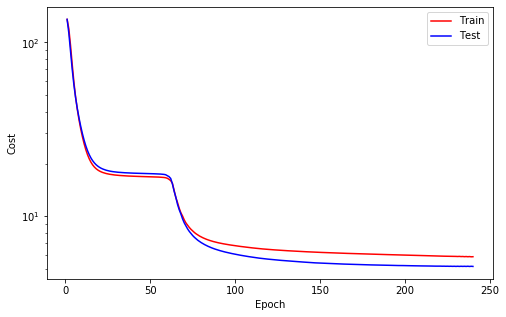

==> EarlyStop patience =  2 | Best test_cost: 5.1439




Epoch   241
Train_cost  = 5.8352 | Test_cost  = 5.1506 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1439




Epoch   242
Train_cost  = 5.8421 | Test_cost  = 5.1445 | 
==> EarlyStop patience =  4 | Best test_cost: 5.1439




Epoch   243
Train_cost  = 5.8281 | Test_cost  = 5.1469 | 
==> EarlyStop patience =  5 | Best test_cost: 5.1439
==> Execute Early Stopping at epoch: 243 | Best test_cost: 5.1439
==> Best model is saved at model/lstm


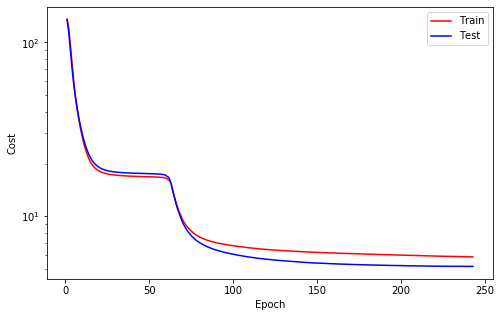

In [11]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [12]:
from luwiji.rnn import illustration

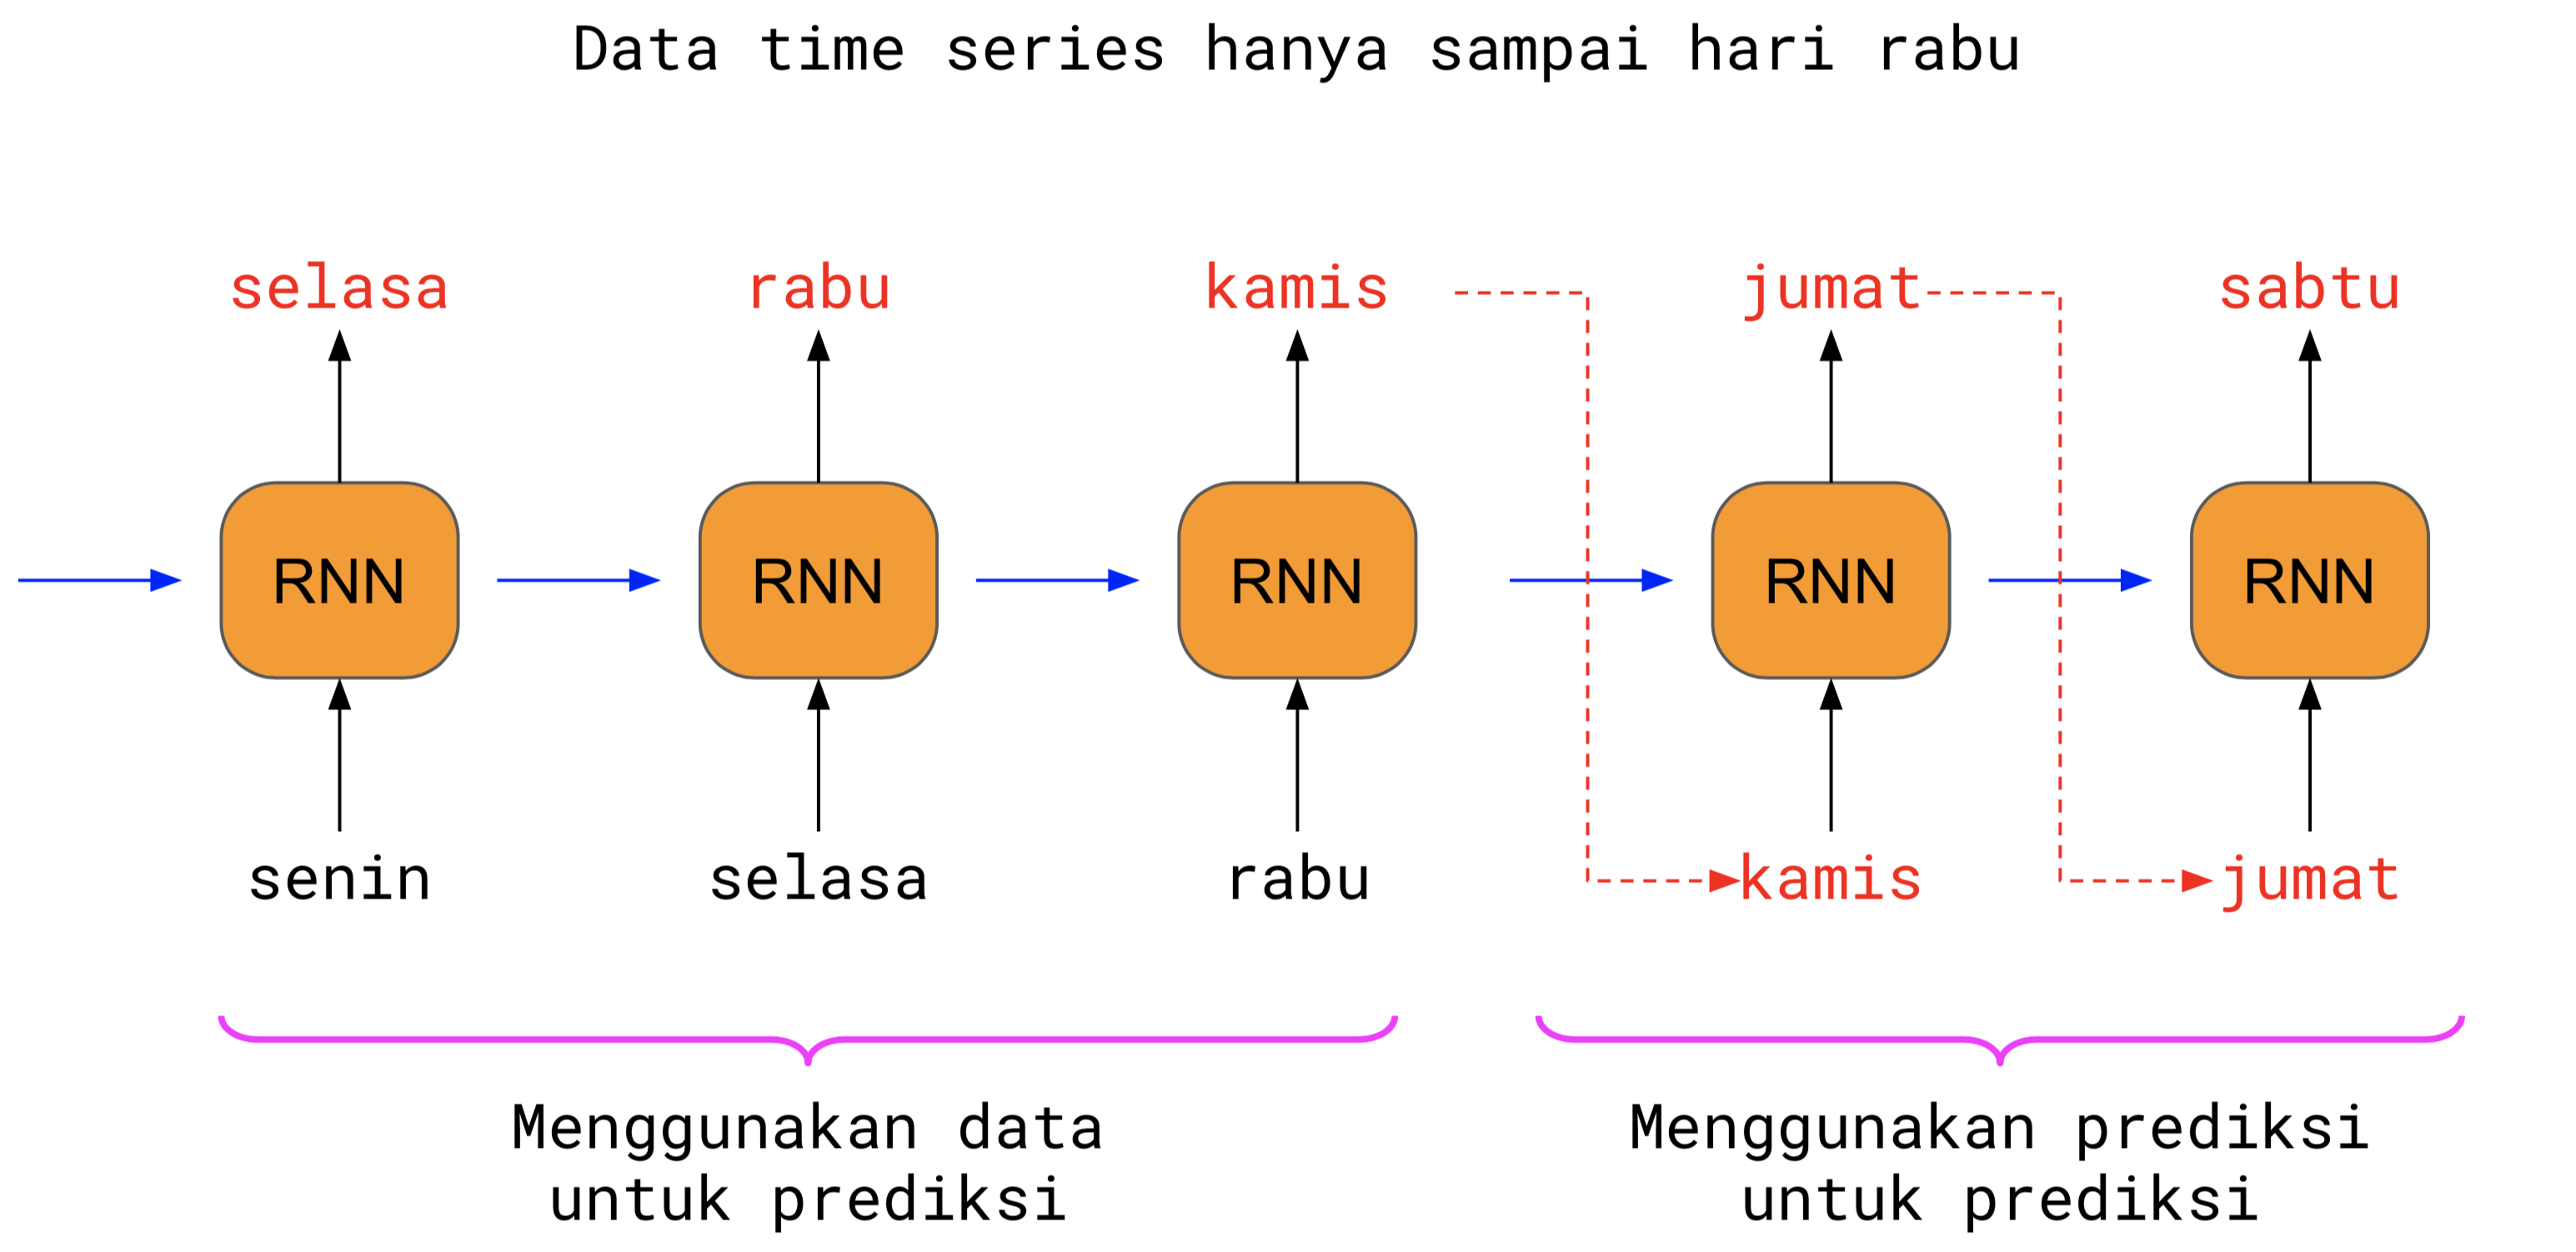

In [13]:
illustration.forecast

In [14]:
from utils import data4pred, pred4pred

In [15]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

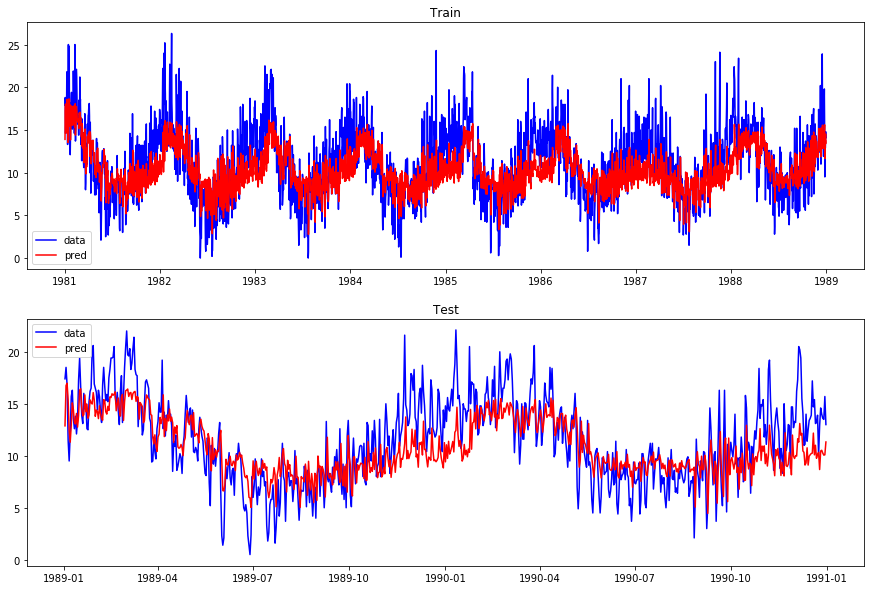

In [16]:
# Data for Pred
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

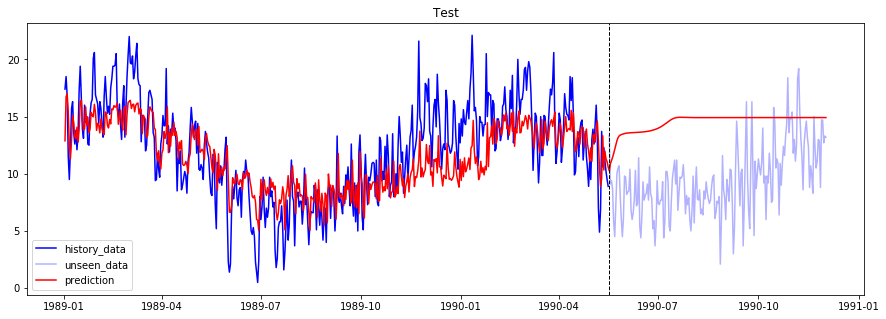

In [17]:
# Pred for Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")